In [1]:
import numpy as np
import timeit
import math
import matplotlib.pyplot as plt

### XYZ to LAMMPS Input

In [2]:
#Load XYZ file
xyz_file = r"./salt_3UC.xyz"
species = np.loadtxt(xyz_file, skiprows = 2, usecols = (0,), dtype = str)
posns = np.loadtxt(xyz_file, skiprows = 2, usecols = (1,2,3))
N_atoms = len(species)
print(N_atoms)

216


In [3]:
species_map = {"Na" : 1, "Cl" : 2}
charge_map = {"Na" : 1, "Cl" : -1}

In [4]:
lammps_file = r"./salt3UC.positions"
with open(lammps_file, "a") as f:
    for i in range(N_atoms):
        f.write(f"{i+1} {species_map[species[i]]} {charge_map[species[i]]} {posns[i,0]} {posns[i,1]} {posns[i,2]} 0 0 0\n")
    
    f.write("\nVelocities\n\n")
    for i in range(N_atoms):
        f.write(f"{i+1} 0 0 0\n")

### Time B-Spline Functions

In [56]:

def M(u, n):
    if n > 2:
        return (u/(n-1))*M(u,n-1) + ((n-u)/(n-1))*M(u-1,n-1)
    elif n == 2:
        if u >= 0 and u <= 2:
            return 1 - np.abs(u-1)
        else:
            return 0
    else:
        print("Shouldn't be here")

#equivalent, time to see whats faster
def M2(u, n):
    return (1/math.factorial(n-1)) * np.sum([((-1)**k)*math.comb(n,k)*np.power(max(u-k, 0), n-1) for k in range(n+1)])


n = 5
u_vals = 7*np.random.random((4000,))

m1 = np.array([M(u_vals[i],n) for i in range(len(u_vals))])
m2 = np.array([M2(u_vals[i], n) for i in range(len(u_vals))])
print(np.sum(m1 - m2))

-3.418684928669254e-13


In [57]:
# num_iterations = 100 #timeit is a fucking garbage library
# execution_time = timeit.Timer(M(u,4), number=num_iterations)
# execution_time2 = timeit.Timer(M2(u,4), number=num_iterations)


# # Calculate average execution time
# average_execution_time = execution_time / num_iterations
# print(average_execution_time)
# average_execution_time2 = execution_time2 / num_iterations
# print(average_execution_time2)

### Charge Interpolation 2D

In [71]:
a = 2
lat_vecs = np.array([[a,0],[0,a]])
rec_lat_vecs = np.array([[1/a,0],[0,1/a]])

n = 5 #spline interpolation order
K1 = 20
K2 = 20

mesh_dims = np.array([K1,K2])

charges = [-1,1,1,-1]
r = np.array([[0.5,0.5], [1.5,0.5], [0.5,1.5], [1.5,1.5]])
u = np.zeros_like(r)

for i in range(len(charges)):
    for dim in range(2):
        u[i,dim] = np.dot(mesh_dims[dim]*rec_lat_vecs[dim], r[i,:])

In [72]:
n_atoms = len(charges)
M_coeffs = np.zeros((n_atoms, 2, n + 1))

for i in range(n_atoms):
    for dim in range(2):
        for j in range(n+1):
            M_coeffs[i,dim,j] = M(u[i,dim] - j, n)

In [77]:
Q = np.zeros((K1,K2))
        
#Full eqn -- the inner loop doesnt need to be over all K1,K2 just n^3 NN
for k1 in range(K1):
    for k2 in range(K2):
        
        for i in range(len(charges)):

            for p1 in range(K1):
                for p2 in range(K2):
                    Q[k1, k2] += charges[i] * M(u[i,0] - k1 - p1*K1, n) * M(u[i,1] - k2 - p2*K2, n)

(0.0, 19.0)

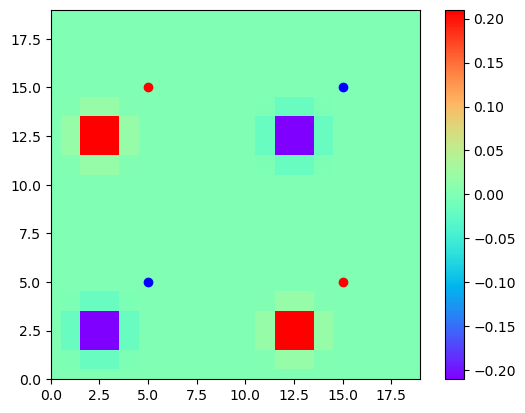

In [78]:
plt.imshow(Q, origin = "lower", cmap = "rainbow")
plt.colorbar()
colors = {-1 : 'b', 1 : 'r'}
for i in range(len(charges)):
    plt.scatter(u[i,0],u[i,1], c = colors[charges[i]])

plt.xlim([0,K1-1])
plt.ylim([0,K2-1])